In [1]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import scipy
from scipy.stats import spearmanr,kendalltau
from scipy.spatial.distance import braycurtis
%matplotlib inline
from statannot import add_stat_annotation
from Bio import SeqIO
from collections import Counter
from sklearn.manifold import TSNE
from matplotlib_venn import venn2

# Read taxonomy

In [2]:
df_tax = pd.read_csv('../../databases/HMPv35/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,9f0b677374166540a820720de4b5c497,Bacteria;Actinobacteriota;Actinobacteria;Propi...,0.999997,Cutibacterium
1,289741fd8c1b48bfc357686cdb16fb1d,Bacteria;Firmicutes;Bacilli;Lactobacillales;St...,0.999985,Streptococcus
2,b2c534e7cecc5f7533915c3ef4f14c22,Bacteria;Firmicutes;Bacilli;Lactobacillales;St...,0.999970,Streptococcus
3,af972eec0b31108567dc3ceaacbcb05d,Bacteria;Firmicutes;Bacilli;Lactobacillales;St...,1.000000,Streptococcus
4,22958f3bf8531f673abde4fba80641ae,Bacteria;Proteobacteria;Gammaproteobacteria;Bu...,0.999945,Neisseria


# Read metadata

In [3]:
df_meta = pd.read_csv("../../databases/HMPv35/metadata.txt", sep="\t", index_col=0)
df_meta['host_visit_id'] = [str(x)+'_'+str(y) for x,y in zip(df_meta.host_subject_id, df_meta.visit_no)]
df_meta = df_meta[df_meta.env.isin(['gastrointestinal_tract','oral_cavity'])]
df_meta.head()

,env,body_site,env_material,psn,sequence_center,host_subject_id,biosample_accession,visit_no,gender,host_visit_id
sample_id,,,,,,,,,,
SRS021079,oral_cavity,hard_palate,sebum,700096626,JCVI,160866180,SAMN00042297,1.0,Female,160866180_1.0
SRS023256,oral_cavity,hard_palate,sebum,700099414,JCVI,964271349,SAMN00044474,NaN,NaN,964271349_nan
SRS050571,oral_cavity,attached keratinized_gingiva,sebum,700108876,BCM,160603188,SAMN00070580,2.0,Male,160603188_2.0
SRS065236,oral_cavity,subgingival_plaque,organic material,700113523,WUGSC,763719065,SAMN00084260,2.0,Female,763719065_2.0
SRS057300,oral_cavity,buccal_mucosa,sebum,700038771,WUGSC,508703490,SAMN00077309,1.0,Female,508703490_1.0


# Read count data (filter out samples with less than 1000 reads)

In [4]:
df_count = pd.read_csv('../../databases/HMPv35/feature_table.txt', sep="\t", index_col=0)
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 1009


#OTU ID,9f0b677374166540a820720de4b5c497,289741fd8c1b48bfc357686cdb16fb1d,b2c534e7cecc5f7533915c3ef4f14c22,af972eec0b31108567dc3ceaacbcb05d,22958f3bf8531f673abde4fba80641ae,43d63e540470fb5bfbe3fd4cb1f9cecf,47c6886e2a9b01dba19ed501877f3275,ad070cf8732b1266da50e879f4b385c1,299c141b8b33629bbf60b183b0185285,b26c46a877e7a7644e295a5d4dc5f053,...,3a1d415cc5320bfb405c681a7f65b96c,b8c305118313f632b3e4d0c675e572a1,a6549becdc7ee00d9760f7ea6b45fe7b,01f578a47fcdfd2fa45eeccf81807ca8,1fafb1a6a0f8f00dad6a46894c7b7655,31aca8d04471a59da24100ad2691b45c,df31f76f9fb977c81601b002aeaccee5,799e3b7aac70efad46a6b18522707d09,6110793b9360904298285d0ef873c788,822dc6489cee23ca376c8398df0093ab
SRS019576,0.00000,0.030253,0.000000,0.053061,0.040548,0.056783,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS022872,0.00076,0.209420,0.035958,0.008357,0.043302,0.041276,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS021263,0.00000,0.194654,0.098012,0.049577,0.000000,0.127713,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS055124,0.00000,0.518565,0.078020,0.004073,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS011300,0.00000,0.000695,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Overlap between HMP and HOMD

In [5]:
df_blast_HOMD = pd.read_csv("../../databases/HMPv35oral/blast_HOMD/blast_HOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_HOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_blast_HOMD.head()

,query_accver,subject_accver,perc_identity,alignment_length,mismatches,gap_opens,qstart,qend,sstart,send,evalue,bitscore
0,289741fd8c1b48bfc357686cdb16fb1d,058BW009,100.0,395,0,0,1,395,886,492,0.0,760
1,289741fd8c1b48bfc357686cdb16fb1d,061DN025,100.0,395,0,0,1,395,888,494,0.0,760
2,289741fd8c1b48bfc357686cdb16fb1d,638_8315,100.0,395,0,0,1,395,886,492,0.0,760
3,b2c534e7cecc5f7533915c3ef4f14c22,058BM035,100.0,395,0,0,1,395,886,492,0.0,760
4,b2c534e7cecc5f7533915c3ef4f14c22,058_8632,100.0,395,0,0,1,395,886,492,0.0,760


In [6]:
len(set(df_blast_HOMD.query_accver)), len(set(df_blast_HOMD.subject_accver))

(113, 224)

In [7]:
fasta_sequences = SeqIO.parse(open("../../databases/HMPv35oral/HMPv35oral.fasta"),'fasta')
all_hmpv35oral_seqs = []
for fasta in fasta_sequences:
    all_hmpv35oral_seqs.append(fasta.id)

In [8]:
fasta_sequences = SeqIO.parse(open("../../databases/HOMD/HOMD.fasta"),'fasta')
all_homd_seqs = []
for fasta in fasta_sequences:
    all_homd_seqs.append(fasta.id)

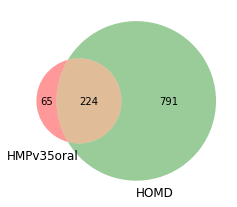

In [9]:
hmpv35oral_only = set(all_hmpv35oral_seqs)-set(df_blast_HOMD.query_accver)
overlap_hmpv35oral = set(df_blast_HOMD.query_accver)
overlap_homd = set(df_blast_HOMD.subject_accver)
homd_only = set(all_homd_seqs)-set(df_blast_HOMD.subject_accver)

fig, ax = plt.subplots(figsize=(5,3))
_ = venn2(subsets = (len(hmpv35oral_only), len(homd_only), len(overlap_homd)), set_labels = ('HMPv35oral', 'HOMD'), ax=ax)
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("venn_diagram_hmpv35oral_homd.svg", dpi=600, bbox_inches='tight')

In [10]:
len(overlap_hmpv35oral), len(overlap_homd)

(113, 224)

# ASVs found in oral cavity

In [11]:
df_relabun_oral = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='oral_cavity'].index))]
df_relabun_oral.loc[:, (df_relabun_oral != 0).any(axis=0)]

#OTU ID,9f0b677374166540a820720de4b5c497,289741fd8c1b48bfc357686cdb16fb1d,b2c534e7cecc5f7533915c3ef4f14c22,af972eec0b31108567dc3ceaacbcb05d,22958f3bf8531f673abde4fba80641ae,43d63e540470fb5bfbe3fd4cb1f9cecf,47c6886e2a9b01dba19ed501877f3275,ad070cf8732b1266da50e879f4b385c1,299c141b8b33629bbf60b183b0185285,b26c46a877e7a7644e295a5d4dc5f053,...,8e70e0c15baa22fa7ac6b9d946be1166,4c7632b4aa41de11b0dcf2e1cc5ef62c,f6defd55a169a7e505289b9555d6c4d5,2850245b4e282f75f8c21f544e127dcd,01f578a47fcdfd2fa45eeccf81807ca8,1fafb1a6a0f8f00dad6a46894c7b7655,31aca8d04471a59da24100ad2691b45c,df31f76f9fb977c81601b002aeaccee5,799e3b7aac70efad46a6b18522707d09,6110793b9360904298285d0ef873c788
SRS019576,0.00000,0.030253,0.000000,0.053061,0.040548,0.056783,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS022872,0.00076,0.209420,0.035958,0.008357,0.043302,0.041276,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS021263,0.00000,0.194654,0.098012,0.049577,0.000000,0.127713,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS055124,0.00000,0.518565,0.078020,0.004073,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS017290,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRS018216,0.00000,0.132334,0.086050,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS043034,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS044830,0.00000,0.000000,0.098952,0.000000,0.000000,0.003239,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS065492,0.00000,0.117254,0.075942,0.029769,0.000000,0.029769,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Compare different oral fraction estimation methods

In [12]:
df_blast_HOMD = pd.read_csv("../../databases/HMPv35/blast_HOMD/blast_HOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_HOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

df_blast_fHOMD = pd.read_csv("../../databases/HMPv35/blast_fHOMD/blast_fHOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_fHOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

df_blast_HMPv35oral = pd.read_csv("../../databases/HMPv35/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35oral.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

In [13]:
all_visits = set(df_meta.host_visit_id)
res = []
for visit in all_visits:
    curr_df = df_meta[df_meta.host_visit_id == visit]
    curr_df = curr_df.loc[set(curr_df.index).intersection(df_relabun.index)]
    if 'stool' not in list(curr_df.body_site):
        continue
    else:
        gut_sample_id = list(curr_df[curr_df.body_site=='stool'].index)
        assert len(gut_sample_id) == 1
        gut_sample_id = gut_sample_id[0]
    # we only consider patients with paired oral and gut samples
    oral_sample_id = list(curr_df[curr_df.body_site.isin(['attached keratinized_gingiva','buccal_mucosa','hard_palate',
                                                          'palatine_tonsils','saliva','subgingival_plaque','supragingival_plaque',
                                                          'throat','tongue_dorsum'])].index)
    if len(oral_sample_id) == 0:
        continue
    
    # oral sequences
    df_oral_seqs = df_relabun.loc[oral_sample_id]
    oral_seqs = list(df_oral_seqs.mean(axis=0)[df_oral_seqs.mean(axis=0)>0].index)
    
    # overlap
    oral_frac_overlap = df_relabun.loc[gut_sample_id, oral_seqs].sum()
    res.append([gut_sample_id, len(oral_seqs), 'Overlap', oral_frac_overlap, 1.0])
    
    # HOMD, all hits
    HOMD_hit = set(df_blast_HOMD.query_accver).intersection(set(df_relabun.columns))
    oral_frac_HOMD = df_relabun.loc[gut_sample_id, HOMD_hit].sum()
    
    # HOMD, hits present in oral cavity
    oral_seqs_w_HOMD_hit = set(oral_seqs).intersection(set(df_blast_HOMD.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_HOMD_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_HOMD_hit].sum()
    
    # fHOMD, all hits
    fHOMD_hit = set(df_blast_fHOMD.query_accver).intersection(set(df_relabun.columns))
    oral_frac_fHOMD = df_relabun.loc[gut_sample_id, fHOMD_hit].sum()
    
    # fHOMD, hits present in oral cavity
    oral_seqs_w_fHOMD_hit = set(oral_seqs).intersection(set(df_blast_fHOMD.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_fHOMD_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_fHOMD_hit].sum()
    
    # HMPv35oral, all hits
    HMPv35oral_hit = set(df_blast_HMPv35oral.query_accver).intersection(set(df_relabun.columns))
    oral_frac_HMPv35oral = df_relabun.loc[gut_sample_id, HMPv35oral_hit].sum()
    
    # HMPv35oral, hits present in oral cavity
    oral_seqs_w_HMPv35oral_hit = set(oral_seqs).intersection(set(df_blast_HMPv35oral.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_HMPv35oral_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_HMPv35oral_hit].sum()
    
    if oral_frac_HOMD==0:
        res.append([gut_sample_id, len(oral_seqs), 'HOMD', oral_frac_HOMD, 1.0])
    else:
        res.append([gut_sample_id, len(oral_seqs), 'HOMD', oral_frac_HOMD, oral_frac_HOMD_overlap/oral_frac_HOMD])
        
    if oral_frac_fHOMD==0:
        res.append([gut_sample_id, len(oral_seqs), 'fHOMD', oral_frac_fHOMD, 1.0])
    else:
        res.append([gut_sample_id, len(oral_seqs), 'fHOMD', oral_frac_fHOMD, oral_frac_fHOMD_overlap/oral_frac_fHOMD])
        
    if oral_frac_HMPv35oral==0:
        res.append([gut_sample_id, len(oral_seqs), 'HMPv35oral', oral_frac_HMPv35oral, 1.0])
    else:
        res.append([gut_sample_id, len(oral_seqs), 'HMPv35oral', oral_frac_HMPv35oral, oral_frac_HMPv35oral_overlap/oral_frac_HMPv35oral])

df_res = pd.DataFrame(res, columns=['SampleID','NumOralASVs', 'Method','OralFrac','FracInOralSample']).set_index('SampleID')
df_res.head()

,NumOralASVs,Method,OralFrac,FracInOralSample
SampleID,,,,
SRS014442,292,Overlap,0.250375,1.0
SRS014442,292,HOMD,0.000313,0.0
SRS014442,292,fHOMD,0.000000,1.0
SRS014442,292,HMPv35oral,0.000000,1.0
SRS016990,228,Overlap,0.322703,1.0


In [14]:
# on average, how many oral ASVs per person?
df_res.reset_index().drop_duplicates('SampleID').NumOralASVs.mean()

247.35357142857143

In [15]:
len(df_res[df_res.Method=='HMPv35oral'].index)

280

In [16]:
len(set(df_res[(df_res.Method=='HMPv35oral') & (df_res.OralFrac==0)].index))

219

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


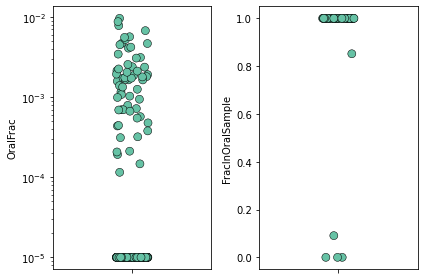

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4))

# oral bacterial fraction
df2plot = df_res[df_res.Method=='HMPv35oral']
df2plot.loc[df2plot.OralFrac == 0, 'OralFrac'] = 1e-5
_ = sns.stripplot(y="OralFrac", data=df2plot, ax=ax[0], s=8, edgecolor='k', linewidth=0.5, palette='Set2', jitter=True)
_ = ax[0].set_yscale('log')

# percentage of fraction present in the oral cavity
df2plot = df2plot[df2plot.OralFrac > 1e-5]
_ = sns.stripplot(y="FracInOralSample", data=df2plot, ax=ax[1], s=8, edgecolor='k', linewidth=0.5, palette='Set2', jitter=True)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("HMP_oral_bacteria_fraction_in_stool.svg", dpi=600, bbox_inches='tight')

In [18]:
len(df_res[(df_res.Method=='HMPv35oral') & (df_res.OralFrac>0) & (df_res.FracInOralSample==1)])

54

In [19]:
len(df_res[(df_res.Method=='HMPv35oral') & (df_res.OralFrac>0) & (df_res.FracInOralSample>0.95)])

56

In [20]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

# #Create a matplotlib colormap from the sns purple color palette
# cmap    = sns.light_palette("purple", reverse=True, as_cmap=True )
# # Normalize to the range of possible values from df["c"]
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# # create a color dictionary (value in c : color from colormap) 
# colors = {}
# for cval in df_res.FracInOralSample:
#     colors.update({cval : cmap(norm(cval))})
    
# _ = sns.stripplot(x="Method", y="OralFrac", data=df_res, ax=ax, order=['HOMD','fHOMD','HMPv35oral'], size=8, hue='FracInOralSample', palette = colors, s=6, edgecolor='k', linewidth=0.5)
# plt.gca().legend_.remove()

# divider = make_axes_locatable(plt.gca())
# ax_cb = divider.new_horizontal(size="5%", pad=0.05)
# fig.add_axes(ax_cb)
# cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical')
# cb1.set_label('Fraction present in oral cavity')
# _ = ax.set_ylim([5e-5,0.5])
# _ = ax.set_yscale('log')

# plt.tight_layout()
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("compare_oral_estimation_methods.svg", dpi=600, bbox_inches='tight')

# mean relative abundance of oral bacteria by overlaps

In [21]:
df_res[df_res.Method=='Overlap'].OralFrac.mean()

0.15625062948164

In [22]:
df_res[(df_res.Method=='Overlap') & (df_res.OralFrac==0)]

,NumOralASVs,Method,OralFrac,FracInOralSample
SampleID,,,,
SRS045493,281,Overlap,0.0,1.0
SRS017103,231,Overlap,0.0,1.0
SRS063921,158,Overlap,0.0,1.0
SRS023851,256,Overlap,0.0,1.0
SRS043769,220,Overlap,0.0,1.0
...,...,...,...,...
SRS017394,301,Overlap,0.0,1.0
SRS054608,170,Overlap,0.0,1.0
SRS018313,241,Overlap,0.0,1.0


In [23]:
df_res[df_res.Method=='Overlap'].sort_values('OralFrac')

,NumOralASVs,Method,OralFrac,FracInOralSample
SampleID,,,,
SRS046349,269,Overlap,0.000000,1.0
SRS014287,336,Overlap,0.000000,1.0
SRS014823,314,Overlap,0.000000,1.0
SRS016056,268,Overlap,0.000000,1.0
SRS020290,248,Overlap,0.000000,1.0
...,...,...,...,...
SRS024208,245,Overlap,0.723236,1.0
SRS023791,196,Overlap,0.769672,1.0
SRS022798,243,Overlap,0.779690,1.0


# Use tSNE to show that oral composition is identifiable

In [24]:
df_relabun_oral = deepcopy(df_relabun)

all_visits = set(df_meta.host_visit_id)
sample_ids_to_keep = []
for visit in all_visits:
    curr_df = df_meta[df_meta.host_visit_id == visit]
    curr_df = curr_df.loc[set(curr_df.index).intersection(df_relabun.index)]
    if 'stool' not in list(curr_df.body_site):
        continue
    else:
        gut_sample_id = list(curr_df[curr_df.body_site=='stool'].index)
        assert len(gut_sample_id) == 1
        gut_sample_id = gut_sample_id[0]
    # we only consider patients with paired oral and gut samples
    oral_sample_id = list(curr_df[curr_df.body_site.isin(['attached keratinized_gingiva','buccal_mucosa','hard_palate',
                                                          'palatine_tonsils','saliva','subgingival_plaque','supragingival_plaque',
                                                          'throat','tongue_dorsum'])].index)
    if len(oral_sample_id) == 0:
        continue
    
    HMPv35oral_hit = set(df_blast_HMPv35oral.query_accver).intersection(set(df_relabun_oral.columns))
    df_relabun_oral.loc[gut_sample_id, set(df_relabun_oral.columns)-HMPv35oral_hit] = 0
    assert np.abs(df_relabun_oral.loc[gut_sample_id, HMPv35oral_hit].sum() - df_relabun_oral.loc[gut_sample_id, :].sum())<1e-6
    oral_frac_HMPv35oral = df_relabun_oral.loc[gut_sample_id, HMPv35oral_hit].sum()
    if oral_frac_HMPv35oral >3e-3:
        sample_ids_to_keep.append(gut_sample_id)
        sample_ids_to_keep.extend(oral_sample_id)
        
df_relabun_oral = df_relabun_oral.loc[sample_ids_to_keep]
df_relabun_oral = df_relabun_oral.div(df_relabun_oral.sum(axis=1), axis=0)
df_relabun_oral = df_relabun_oral.loc[:, (df_relabun_oral != 0).any(axis=0)]
df_relabun_oral.head()

#OTU ID,9f0b677374166540a820720de4b5c497,289741fd8c1b48bfc357686cdb16fb1d,b2c534e7cecc5f7533915c3ef4f14c22,af972eec0b31108567dc3ceaacbcb05d,22958f3bf8531f673abde4fba80641ae,43d63e540470fb5bfbe3fd4cb1f9cecf,47c6886e2a9b01dba19ed501877f3275,ad070cf8732b1266da50e879f4b385c1,299c141b8b33629bbf60b183b0185285,b26c46a877e7a7644e295a5d4dc5f053,...,0432ff0c7a59f181315cbc30409b671d,d65cecfb190f0d2b75cb21d49d50da29,0105470bb54af1ad865d0a0c11a9dadc,f32e5676ca424bcb3373caeba533937d,a7ffca64873cc31ef98ed08c477aa9c0,a2cbd4dad31e8e5e035fadad6768ac46,652ac807b13586a54a254e8e67211d26,7292544d95d277db25487d2d7819f4db,0aaca17d3e795f610f3a66a0fd127891,05a346e6f838434531b548c798fd4de2
SRS052326,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS048228,0.0,0.291598,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.304858,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS058791,0.0,0.000000,0.0,0.000000,0.002104,0.000000,0.0,0.0,0.123780,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS048709,0.0,0.000000,0.0,0.057386,0.061253,0.013612,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRS054907,0.0,0.000000,0.0,0.000000,0.003316,0.000000,0.0,0.0,0.165923,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
# input matrix: sample by feature
tsne_data = TSNE(n_components=2, random_state=42, verbose=0, n_jobs=-1, n_iter=5000, metric='braycurtis').fit_transform(df_relabun_oral.values)
tsne_df = pd.DataFrame(data=np.vstack((tsne_data.T, df_meta.loc[df_relabun_oral.index,'env'], df_meta.loc[df_relabun_oral.index,'host_visit_id'])).T, columns=('tSNE1', 'tSNE2', 'Bodysite', 'Host_visit_id'))
tsne_df.tSNE1 = tsne_df.tSNE1.astype(float)
tsne_df.tSNE2 = tsne_df.tSNE2.astype(float)
tsne_df.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


,tSNE1,tSNE2,Bodysite,Host_visit_id
0,-8.923002,-2.673304,gastrointestinal_tract,158256496_2.0
1,6.775856,-3.913912,oral_cavity,158256496_2.0
2,-0.303744,-3.668772,oral_cavity,158256496_2.0
3,-0.651973,-0.599433,oral_cavity,158256496_2.0
4,-7.631546,-9.430041,oral_cavity,158256496_2.0


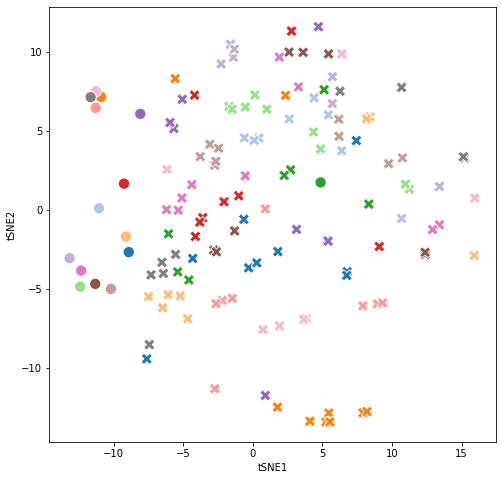

In [154]:
fig, ax = plt.subplots(figsize=(8,8))
_ = sns.scatterplot(x="tSNE1", y="tSNE2", hue='Host_visit_id', style='Bodysite', data=tsne_df, s=128, palette='tab20')
_ = ax.get_legend().remove()

# Mean relative abundance of oral bacteria in healthy people

In [25]:
df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='gastrointestinal_tract'].index)), 
               set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).mean()

0.0005003651255655415

# Mean relative abundance of total and oral Prevotella in stools

In [58]:
prevotella_asvs = list(df_tax.loc[df_tax.LowestTaxonomy.isin([x for x in df_tax.LowestTaxonomy if x.startswith('Prevotella') and x!='Prevotellaceae-bacterium-Marseille-P2826']),'ASV'])
oral_prevotella_asvs = list(df_blast_HMPv35oral[df_blast_HMPv35oral.query_accver.isin(prevotella_asvs)].query_accver)
print(len(prevotella_asvs), len(oral_prevotella_asvs))

2292 24


In [59]:
df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='gastrointestinal_tract'].index)), 
               set(df_relabun.columns).intersection(set(prevotella_asvs))].sum(axis=1).mean()

0.023664395530382337

In [60]:
df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='gastrointestinal_tract'].index)), 
               set(df_relabun.columns).intersection(set(oral_prevotella_asvs))].sum(axis=1).mean()

9.717025637886294e-07

## Correlate oral bacterial fraction and sequencing depth

SpearmanrResult(correlation=0.27684514090283935, pvalue=2.5505735984681135e-06)
KendalltauResult(correlation=0.21259798010646977, pvalue=4.607344147445636e-06)


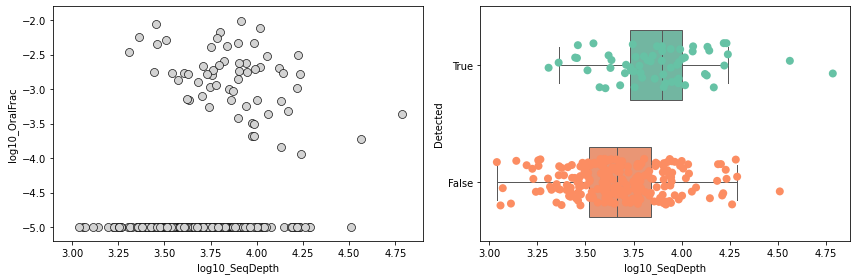

In [68]:
# compute sequence depth
df_count_sum = pd.merge(df_meta[df_meta.body_site=='stool'], df_count.sum(axis=1).to_frame().rename({0:'SeqDepth'}, axis=1), left_index=True, right_index=True, how='inner')
df_count_sum = pd.merge(df_count_sum, df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1),
                        left_index=True, right_index=True, how='inner')
df_count_sum = df_count_sum.loc[set(df_res.index)]
df_count_sum['Detected'] = (df_count_sum.OralFrac>0).astype(str)
df_count_sum.loc[df_count_sum.OralFrac==0,'OralFrac'] = 1e-5
df_count_sum['log10_SeqDepth'] = np.log10(df_count_sum['SeqDepth'])
df_count_sum['log10_OralFrac'] = np.log10(df_count_sum['OralFrac'])

# spearman correlation
print(spearmanr(df_count_sum.log10_SeqDepth, df_count_sum.log10_OralFrac))
print(kendalltau(df_count_sum.log10_SeqDepth, df_count_sum.log10_OralFrac))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

_ = sns.scatterplot(x="log10_SeqDepth", y="log10_OralFrac", data=df_count_sum[df_count_sum.OralFrac>0], ax=ax[0], s=64, color='lightgray', edgecolor='k')
#_ = sns.regplot(x="log10_SeqDepth", y="log10_OralFrac", data=df_count_sum[df_count_sum.OralFrac>0], ax=ax, scatter=False, color="red")
_ = ax[0].set_ylim([-5.2,-1.8])
_ = ax[0].set_xlim([2.9,4.9])

_ = sns.boxplot(y="Detected", x="log10_SeqDepth", data=df_count_sum, width=.6, ax=ax[1], order=['True','False'], palette='Set2', linewidth=1, showfliers=False)
_ = sns.stripplot(y="Detected", x="log10_SeqDepth", data=df_count_sum, size=8, color=".3", linewidth=0, ax=ax[1], jitter=0.2, palette='Set2', dodge=True, order=['True','False'])
# _ = add_stat_annotation(ax[1], data=df_count_sum, y="Detected", x="log10_SeqDepth", order=['False','True'],
#                        comparisons_correction=None,
#                        box_pairs=[("False","True")],
#                        test='t-test_welch', text_format='star', loc='inside', verbose=1)
#_ = ax[1].set_ylim([-4,1.5])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatterplot_depth_vs_oral_fraction.svg", dpi=600, bbox_inches='tight')

In [56]:
scipy.stats.ttest_ind(df_count_sum[df_count_sum.Detected=='False'].log10_SeqDepth, 
                      df_count_sum[df_count_sum.Detected=='True'].log10_SeqDepth,
                      equal_var=False
                     )

Ttest_indResult(statistic=-5.131597653130295, pvalue=1.598285579407225e-06)